## Data Description

This is the final project for "How to win a data science competition" Coursera course

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 


**File descriptions**

*sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

*test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

*sample_submission.csv - a sample submission file in the correct format.

*items.csv - supplemental information about the items/products.

*item_categories.csv  - supplemental information about the items categories.

*shops.csv- supplemental information about the shops.

**Data fields**

*ID - an Id that represents a (Shop, Item) tuple within the test set

*shop_id - unique identifier of a shop

*item_id - unique identifier of a product

*item_category_id - unique identifier of item category

*item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

*item_price - current price of an item

*date - date in format dd/mm/yyyy

*date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

*item_name - name of item

*shop_name - name of shop

*item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
sales_data = pd.read_csv('sales_train.csv',)
sample_submission = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test_data = pd.read_csv('test.csv')

In [3]:
sales_data.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [4]:
test_data

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [5]:
sample_submission.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


creating function to print all the related data info

In [6]:
def basic_eda(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)

In [7]:
print("=============================Sales Data=============================")
basic_eda(sales_data)
print("=============================Test data=============================")
basic_eda(test_data)
print("=============================Item Categories=============================")
basic_eda(item_cat)
print("=============================Items=============================")
basic_eda(items)
print("=============================Shops=============================")
basic_eda(shops)
print("=============================Sample Submission=============================")
basic_eda(sample_submission)

=============================Sales Data=============================
----------TOP 5 RECORDS--------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------

In [8]:
sales_data['date'] = pd.to_datetime(sales_data['date'], format = '%d.%m.%Y')

In [9]:
sales_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [10]:
dataset = sales_data.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [11]:
pd.set_option('display.max_rows',20)
dataset

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                      ...  .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
59      22154              1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22155              0   0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0   
        22162              0   0  0  0  0  0  0  0  0  0  ...  0  9  4  1  1   
        22164              0   0  0  0  0  0  0  0  0  0  ...  0  2  1  2  0   
        22167              0   0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  
...             .. .. .. .. ..  
59      22154    0  0  0  0  0  
        22155    0  0  0  0  0  
        22162    0  0  1  0  0  
        22164    0  1  0  0  0  
        22167    0  0  0  0  0  

[424124 rows x 34 columns]

In [12]:
dataset.reset_index(inplace = True)

In [13]:
dataset

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   
...                ...     ...          ...  .. .. .. .. .. .. ..  ... .. ..   
424119              59   22154            1   0  0  0  0  0  0  0  ...  0  0   
424120              59   22155            0   0  0  0  0  0  1  0  ...  0  0   
424121              59   22162            0   0  0  0  0  0  0  0  ...  0  9   
424122              59   22164            0   0  0  0  0  0  0  0  ...  0  2   
424123              59   22167            0   0  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  
...            .. .. .. .. .. .. .. ..  
424119          0  0  0  0  0  0  0  0  
424120          0  0  0  0  0  0  0  0  
424121          4  1  1  0  0  1  0  0  
424122          1  2  0  0  1  0  0  0  
424123          0  0  0  0  0  0  0  0  

[424124 rows x 36 columns]

In [14]:
dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')

C:\Users\USER\AppData\Local\Temp/ipykernel_34656/2941923082.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [15]:
dataset

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
dataset.fillna(0,inplace = True)
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
y_train = dataset.values[:,-1:]

X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [19]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [20]:
model_lstm = Sequential()
model_lstm.add(LSTM(units = 64,input_shape = (X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(1))

model_lstm.compile(loss = 'mse', optimizer = 'adam', metrics = ['mean_squared_error'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 18s 326ms/step - loss: 30.5472 - mean_squared_error: 30.5472
Epoch 2/10
53/53 [==============================] - 17s 323ms/step - loss: 30.2366 - mean_squared_error: 30.2366
Epoch 3/10
53/53 [==============================] - 18s 332ms/step - loss: 30.0435 - mean_squared_error: 30.0435
Epoch 4/10
53/53 [==============================] - 18s 343ms/step - loss: 29.9924 - mean_squared_error: 29.9924
Epoch 5/10
53/53 [==============================] - 18s 348ms/step - loss: 29.8964 - mean_squared_error: 29.8964
Epoch 6/10
53/53 [==============================] - 19s 357ms/step - loss: 29.7946 - mean_squared_error: 29.7946
Epoch 7/10
53/53 [==============================] - 19s 350ms/step - loss: 29.7019 - mean_squared_error: 29.7019
Epoch 8/10
53/53 [==============================] - 18s 347ms/step - loss: 29.6599 - mean_squared_error: 29.6599
Epoch 9/10
53/53 [==============================] - 19s 358ms/step - loss: 29.6942 - mean_square

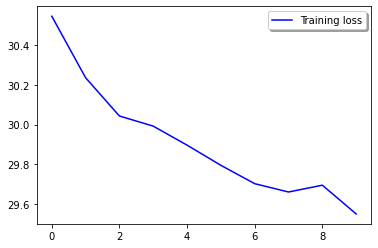

In [22]:
plt.plot(history_lstm.history['loss'], color ='b', label="Training loss")
plt.legend(loc='best',shadow=True)

In [23]:
submission_pfs = model_lstm.predict(X_test)
submission_pfs = submission_pfs.clip(0,20)
submission = pd.DataFrame({'ID':test_data['ID'], 'item_cnt_month':submission_pfs.ravel()})
submission.to_csv('sub_pfs.csv', index=False)

In [24]:
submission.head(3)

,ID,item_cnt_month
0,0,0.460066
1,1,0.127882
2,2,0.787123


In [25]:
submission.shape, test_data.shape

((214200, 2), (214200, 3))